# Project Notebook II: Unsupervised Learning

David Chen

Please note, the downloaded data is already mean-centered, variance-scaled. No further data preprocessing was performed.

In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sagemaker
from sagemaker import get_execution_role
import boto3

## My custom helper functions
from helpers import *

## Step 1. Sagemaker Resources & Processed Data Saved in S3

In [2]:
sagemaker_session = sagemaker.Session()
sagemaker_session

In [3]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::644307290749:role/service-role/AmazonSageMaker-ExecutionRole-20210527T073969'

In [4]:
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-us-west-1-644307290749'

In [8]:
## Load processed features:
genes = pd.read_csv(get_s3_uri("assets/processed_data/genes.csv", bucket), index_col=0)
genes.shape

(999, 20528)

In [9]:
## Load processed patient annotations (with defined class label):
clinical = pd.read_csv(get_s3_uri("assets/processed_data/clinical.csv", bucket))
clinical.shape

(999, 15)

In [10]:
## Check to see if patient IDs in the 2 DataFrames match
all(genes.index == clinical['Sample ID'])

True

### Exclude genes with missing values

In [11]:
genesWithNan = genes.columns[genes.isna().any()].tolist()
len(genesWithNan)

319

In [12]:
genes = genes.dropna(axis=1)
genes.shape

(999, 20209)

## Step 2. Explore Data via Unsupervised Learning

Here, we will perform an **unsupervised** ML to **visualize** whether there are any patterns in the feature space with the defined class label.

Specifically, we will reduce the dimension down to 2 (PC1 & PC2) for the sake of visualization.

In [13]:
def plot_dimred(X_r, y, title, labels=[0,1],
                target_names=["Other","Triple Neg."], colors=['navy','darkorange']):
    """ Plots dimensionality reduced data """
    plt.figure(dpi=100)

    for color, label, target_name in zip(colors, labels, target_names):
        plt.scatter(
            X_r[y == label, 0], 
            X_r[y == label, 1], 
            color=color,
            label=target_name
        )

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")

    plt.show()

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(genes)

PCA(n_components=2)

In [15]:
X_pca = pca.transform(genes)

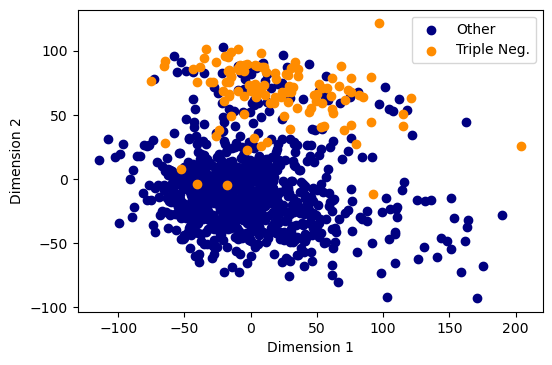

In [16]:
plot_dimred(X_pca, clinical["Label"].values ,"PCA")

There is a clear localization of Triple Negative Breast Cancer patients in Quadrant I & II of the PCA-reduced feature space. This result may be an indicator that:

* At the first glance, PCA-reduced data seems to localize into two clusters.
* There is an association between features (genes) with the Class Label, indicated by the majority of triple negative data points localizing in the top cluster.
* If we are able to see clear-cut differences in Unsupervised Learning results, we may be able to yield robust learner using Supervised Learning.